In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from datetime import datetime
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
%matplotlib inline

# 1. Load Data

In [26]:
일별 = pd.read_csv("/content/drive/MyDrive/BigCon/0821_일별데이터.csv", parse_dates={'dt': ['base_date']}, index_col='dt')
#월별 = pd.read_csv("/content/drive/MyDrive/BigCon/0821_월별데이터.csv", parse_dates={'dt': ['year_month']}, index_col='dt') 
일별.head()

,year_month,emd_nm,em_cnt,em_g,pay_amt,visit_sum_short,idx_visit_short,total_pop,total_idx,total_pop(for),total_idx(for)
dt,,,,,,,,,,,
2018-01-01,201801,건입동,668,1708250,51079,4777.1626,2.0,3.710493e+05,1.0,10050.8070,1.0
2018-01-01,201801,남원읍,304,1239600,37110,3552.3268,2.0,5.160217e+05,0.0,10167.8231,0.0
2018-01-01,201801,노형동,3903,9357900,278317,9654.0358,0.0,1.667941e+06,1.0,58525.3567,0.0
2018-01-01,201801,대륜동,650,1717700,50076,1347.0481,2.0,4.933991e+05,1.0,5882.1312,2.0
2018-01-01,201801,대정읍,309,1264950,37872,1988.0280,2.0,5.332329e+05,0.0,28157.4663,0.0


In [27]:
# 일단 건입동에 대해서
일별 = 일별[일별['emd_nm']=='건입동']
일별 = 일별.drop(['emd_nm'], axis=1)

In [28]:
dataset_train_actual = 일별.copy()
dataset_train_actual.isnull().sum() 
dataset_train_actual = dataset_train_actual.reset_index()

In [29]:
dataset_train_timeindex = dataset_train_actual.set_index('dt')
dataset_train = dataset_train_actual.copy()

In [30]:
# Select features (columns) to be involved intro training and predictions
cols = [#'dt',
#'year_month',
#'em_cnt',
 'em_g',
#'pay_amt',
 'visit_sum_short',
 'idx_visit_short',
 'total_pop',
 'total_idx',
 'total_pop(for)',
 'total_idx(for)']

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['dt'])
datelist_train = [date for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (1276, 11)
All timestamps == 1276
Featured selected: ['em_g', 'visit_sum_short', 'idx_visit_short', 'total_pop', 'total_idx', 'total_pop(for)', 'total_idx(for)']


# 2. Data Preprocessing

In [31]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1276, 7).


array([[1.7082500e+06, 4.7771626e+03, 2.0000000e+00, ..., 1.0000000e+00,
        1.0050807e+04, 1.0000000e+00],
       [1.8411500e+06, 3.8057432e+03, 0.0000000e+00, ..., 1.0000000e+00,
        9.8287922e+03, 1.0000000e+00],
       [1.4114500e+06, 3.3054360e+03, 2.0000000e+00, ..., 1.0000000e+00,
        9.2448264e+03, 1.0000000e+00],
       ...,
       [1.3235500e+06, 5.1411600e+01, 0.0000000e+00, ..., 1.0000000e+00,
        9.4809120e+03, 1.0000000e+00],
       [1.3106500e+06, 3.9565200e+01, 0.0000000e+00, ..., 1.0000000e+00,
        8.8773548e+03, 1.0000000e+00],
       [1.1698500e+06, 6.5875900e+01, 0.0000000e+00, ..., 1.0000000e+00,
        8.4850769e+03, 1.0000000e+00]])

In [32]:
# Feature Scaling
# 입력 피쳐와 예측해야 하는 대상에 대해 다른 두 개의 스케일러를 만듦
# 입력 피쳐에도 음쓰배출량(em_g) 존재

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[ 1.11068807],
       [ 1.61500656],
       [-0.01558527],
       ...,
       [-0.34914129],
       [-0.3980932 ],
       [-0.93238999]])

In [80]:
# Creating a data structure with 72 timestamps and 1 output
X_train = []
y_train = []

n_future = 30   # Number of days we want top predict into the future 
n_past = 30   # Number of past days we want to use to predict the future 

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1217, 30, 7).
y_train shape == (1217, 1).


# 3. Modeling
* Conv1D: 입력 시계열의 평활화 -> 입력 피처의 이동 평균 또는 이동 표준편차 값을 추가할 필요 없음
* LSTM: 여러 입력 변수 모델링 가능 -> 3D 입력 벡터
* 다대다 예측: 자동회귀분석 vs __싱글샷 예측__

In [81]:
model = tf.keras.models.Sequential([
 
  # 모델링 부분은 튜닝 필요 
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                         strides=1, padding="same",
                         activation="relu",
                         input_shape=[None, 7]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  #tf.keras.layers.LSTM(128),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
  #tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1),
  # tf.keras.layers.Dense(3,kernel_initializer=tf.initializers.zeros),
  tf.keras.layers.Lambda(lambda x: x * 200),
  #tf.keras.layers.Reshape([24, 3])
])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [82]:
# %%time
# es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

# tb = TensorBoard('logs')

In [83]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          704       
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
_________________________________________________________________
lambda_4 (Lambda)            (None, 1)                 0         
Total params: 42,241
Trainable params: 42,241
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
31/31 [==============================] - 9s 80ms/step - loss: 12.0872 - mse: 266.3871 - val_loss: 11.2212 - val_mse: 229.9789
Epoch 2/100
31/31 [==============================] - 1s 33ms/step - loss: 6.3631 - mse: 74.8245 - val_loss: 9.6988 - val_mse: 150.9121
Epoch 3/100
31/31 [==============================] - 1s 34ms/step - loss: 4.3584 - mse: 37.3122 - val_loss: 6.4812 - val_mse: 72.3733
Epoch 4/100
31/31 [==============================] - 1s 34ms/step - loss: 3.3570 - mse: 23.4216 - val_loss: 6.6330 - val_mse: 71.7637
Epoch 5/100
31/31 [==============================] - 1s 33ms/step - loss: 2.7958 - mse: 17.0796 - val_loss: 5.0794 - val_mse: 45.4196
Epoch 6/100
31/31 [==============================] - 1s 34ms/step - loss: 2.4702 - mse: 13.6626 - val_loss: 5.8619 - val_mse: 57.4272
Epoch 7/100
31/31 [==============================] - 1s 33ms/step - loss: 2.1719 - mse: 11.0648 - val_loss: 5.4013 - val_mse: 51.5065
Epoch 8/100
31/31 [==============================] - 1s 3

In [85]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='D').tolist()
#datelist_future = pd.date_range(start='2021-06-30', periods=n_future, freq='D').tolist()

'''
Remember, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [86]:
datelist_future

[Timestamp('2021-06-30 00:00:00', freq='D'),
 Timestamp('2021-07-01 00:00:00', freq='D'),
 Timestamp('2021-07-02 00:00:00', freq='D'),
 Timestamp('2021-07-03 00:00:00', freq='D'),
 Timestamp('2021-07-04 00:00:00', freq='D'),
 Timestamp('2021-07-05 00:00:00', freq='D'),
 Timestamp('2021-07-06 00:00:00', freq='D'),
 Timestamp('2021-07-07 00:00:00', freq='D'),
 Timestamp('2021-07-08 00:00:00', freq='D'),
 Timestamp('2021-07-09 00:00:00', freq='D'),
 Timestamp('2021-07-10 00:00:00', freq='D'),
 Timestamp('2021-07-11 00:00:00', freq='D'),
 Timestamp('2021-07-12 00:00:00', freq='D'),
 Timestamp('2021-07-13 00:00:00', freq='D'),
 Timestamp('2021-07-14 00:00:00', freq='D'),
 Timestamp('2021-07-15 00:00:00', freq='D'),
 Timestamp('2021-07-16 00:00:00', freq='D'),
 Timestamp('2021-07-17 00:00:00', freq='D'),
 Timestamp('2021-07-18 00:00:00', freq='D'),
 Timestamp('2021-07-19 00:00:00', freq='D'),
 Timestamp('2021-07-20 00:00:00', freq='D'),
 Timestamp('2021-07-21 00:00:00', freq='D'),
 Timestamp

In [87]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])

y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

In [88]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['em_g']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['em_g']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))
#PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['em_g']).set_index(pd.Series(datelist_train[]))
# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
# PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

In [89]:
PREDICTIONS_FUTURE

,em_g
2021-06-30,1640363.250
2021-07-01,1281335.125
2021-07-02,1748169.500
2021-07-03,1556688.875
2021-07-04,1542129.625
2021-07-05,1823494.375
2021-07-06,1719785.000
2021-07-07,1722686.500
2021-07-08,1600532.125
2021-07-09,2293562.250


In [90]:
PREDICTION_TRAIN

,em_g
2018-03-31,1377849.000
2018-04-01,1367277.875
2018-04-02,1389468.875
2018-04-03,1251162.125
2018-04-04,1242474.125
...,...
2021-06-26,1977528.125
2021-06-27,1926864.000
2021-06-28,1740535.375
2021-06-29,1630191.750


# 4. Visualize

### n_past=30

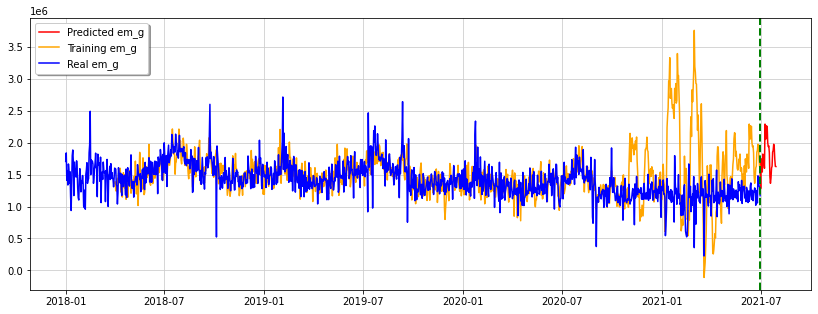

In [91]:
# Set plot size 
# from pylab import rcParams
plt.rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-06-30'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['em_g'], color='r', label='Predicted em_g')
plt.plot(PREDICTION_TRAIN.loc[:START_DATE_FOR_PLOTTING].index, PREDICTION_TRAIN.loc[:START_DATE_FOR_PLOTTING]['em_g'], color='orange', label='Training em_g')
plt.plot(dataset_train_timeindex.loc[:START_DATE_FOR_PLOTTING].index, dataset_train_timeindex.loc[:START_DATE_FOR_PLOTTING]['em_g'], color='b', label='Real em_g')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc')

plt.legend(shadow=True)
# plt.title('Predcitions and Acutal Global Active power values', family='Arial', fontsize=12)
# plt.xlabel('Timeline', family='Arial', fontsize=10)
# plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
# plt.xticks(rotation=45, fontsize=8)
plt.show() 

### n_past=72

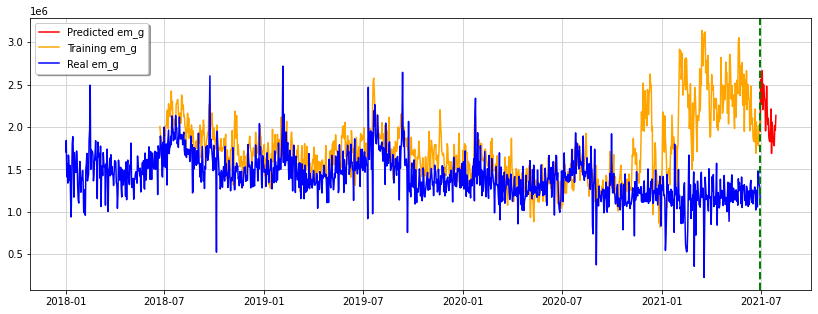

In [79]:
# Set plot size 
# from pylab import rcParams
plt.rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-06-30'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['em_g'], color='r', label='Predicted em_g')
plt.plot(PREDICTION_TRAIN.loc[:START_DATE_FOR_PLOTTING].index, PREDICTION_TRAIN.loc[:START_DATE_FOR_PLOTTING]['em_g'], color='orange', label='Training em_g')
plt.plot(dataset_train_timeindex.loc[:START_DATE_FOR_PLOTTING].index, dataset_train_timeindex.loc[:START_DATE_FOR_PLOTTING]['em_g'], color='b', label='Real em_g')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc')

plt.legend(shadow=True)
# plt.title('Predcitions and Acutal Global Active power values', family='Arial', fontsize=12)
# plt.xlabel('Timeline', family='Arial', fontsize=10)
# plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
# plt.xticks(rotation=45, fontsize=8)
plt.show() 

### n_past=180

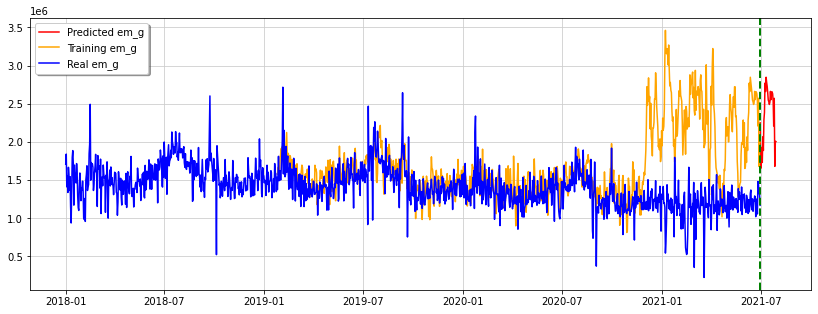

In [69]:
# Set plot size 
# from pylab import rcParams
plt.rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-06-30'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['em_g'], color='r', label='Predicted em_g')
plt.plot(PREDICTION_TRAIN.loc[:START_DATE_FOR_PLOTTING].index, PREDICTION_TRAIN.loc[:START_DATE_FOR_PLOTTING]['em_g'], color='orange', label='Training em_g')
plt.plot(dataset_train_timeindex.loc[:START_DATE_FOR_PLOTTING].index, dataset_train_timeindex.loc[:START_DATE_FOR_PLOTTING]['em_g'], color='b', label='Real em_g')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc')

plt.legend(shadow=True)
# plt.title('Predcitions and Acutal Global Active power values', family='Arial', fontsize=12)
# plt.xlabel('Timeline', family='Arial', fontsize=10)
# plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
# plt.xticks(rotation=45, fontsize=8)
plt.show() 

In [266]:
# import matplotlib.pyplot as plt

# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])

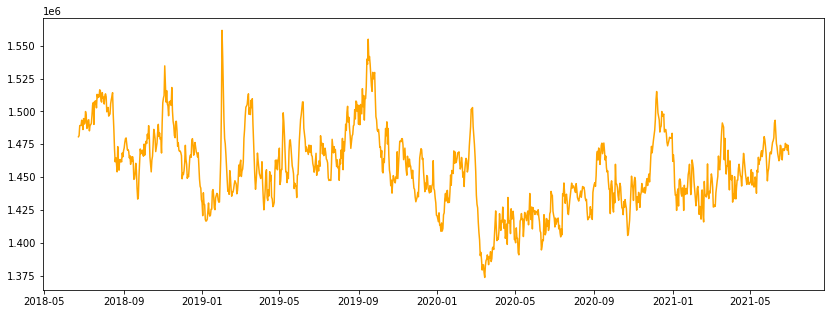

In [267]:
plt.plot(PREDICTION_TRAIN.loc[:START_DATE_FOR_PLOTTING].index, PREDICTION_TRAIN.loc[:START_DATE_FOR_PLOTTING]['em_g'], color='orange', label='Training predictions')

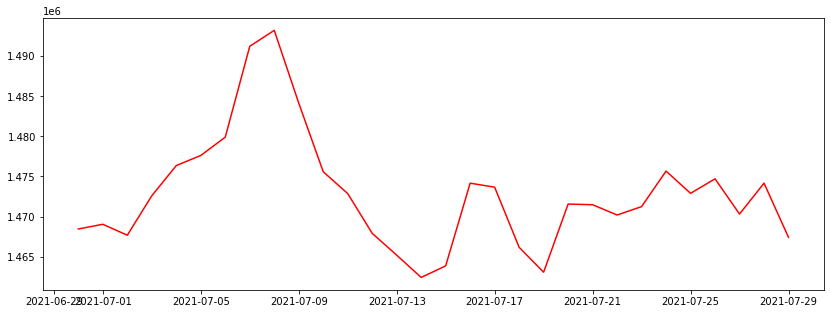

In [268]:
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['em_g'], color='r')

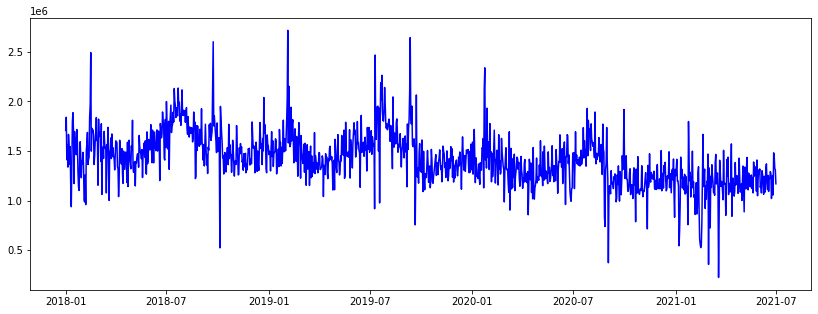

In [269]:
plt.plot(dataset_train_timeindex.loc[:START_DATE_FOR_PLOTTING].index, dataset_train_timeindex.loc[:START_DATE_FOR_PLOTTING]['em_g'], color='b')